In [2]:
!nvidia-smi

Tue Dec 31 23:58:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   45C    P8             23W /  200W |     454MiB /   8192MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
print(torch.__version__)

d:\software\anaconda3\envs\base38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\software\anaconda3\envs\base38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\software\anaconda3\envs\base38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


2.0.1+cu118


### 原生成翻页效果代码

In [128]:
import numpy as np
from PIL import Image
import math
import time

# 常量
minAmount = -0.16
maxAmount = 1.3
PI = 3.141592653589793
scale = 512.0
sharpness = 3.0
cylinderRadius = 1.0 / (PI * 2.0)

# 变量初始化
curlExtent = 0.0
amount = 0.0
cylinderCenter = 0.0
cylinderAngle = 0.0


# 击中点计算函数
def hitPoint(hitAngle, yc, point, rrotation):
    hitPoint = hitAngle / (2.0 * PI)
    point_transformed = np.dot(rrotation, point)[:3]  # 直接使用 3D 向量
    point_transformed[1] = hitPoint
    return point_transformed


# 抗锯齿函数
def antiAlias(color1, color2, distance):
    distance *= scale
    if distance < 0.0:
        return color2
    if distance > 2.0:
        return color1
    dd = pow(1.0 - distance / 2.0, sharpness)
    color2_np = np.array(color2, dtype=np.float32)
    color1_np = np.array(color1, dtype=np.float32)
    result = (color2_np - color1_np) * dd + color1_np
    result = np.clip(result, 0.0, 1.0)
    return tuple(result)


# 距离到边缘函数
def distanceToEdge(point, width, height):
    x, y = point[:2]
    dx = abs(x - 0.5)
    dy = abs(y - 0.5)
    if x < 0.0:
        dx = -x
    elif x > 1.0:
        dx = x - 1.0
    if y < 0.0:
        dy = -y
    elif y > 1.0:
        dy = y - 1.0
    if (x < 0.0 or x > 1.0) and (y < 0.0 or y > 1.0):
        return math.sqrt(dx * dx + dy * dy)
    return min(dx, dy)


# 透视为前景函数
def seeThrough(yc, p, rotation, rrotation, iChannel0, bgColor):
    hitAngle = PI - (math.acos(yc / cylinderRadius) - cylinderAngle)
    point = hitPoint(hitAngle, yc, np.dot(rotation, np.append(p, 0.0))[:3], rrotation)  # 使用 3D 向量
    if yc <= 0.0 and (point[0] < 0.0 or point[1] < 0.0 or point[0] > 1.0 or point[1] > 1.0):
        return (0.0, 0.0, 0.0, 0.0)
    if yc > 0.0:
        pixel = iChannel0.getpixel((int(p[0] * iChannel0.width), int(p[1] * iChannel0.height)))
        color = (*pixel, 255) if len(pixel) == 3 else pixel
        return tuple(c / 255.0 for c in color)
    pixel = iChannel0.getpixel((int(point[0] * iChannel0.width), int(point[1] * iChannel0.height)))
    color = (*pixel, 255) if len(pixel) == 3 else pixel
    tcolor = (0.0, 0.0, 0.0, 0.0)
    return antiAlias(tuple(c / 255.0 for c in color), tcolor, distanceToEdge(point, iChannel0.width, iChannel0.height))


# 带阴影的透视为前景函数
def seeThroughWithShadow(yc, p, point, rotation, rrotation, iChannel0, bgColor):
    shadow = distanceToEdge(point, iChannel0.width, iChannel0.height) * 30.0
    shadow = (1.0 - shadow) / 3.0
    if shadow < 0.0:
        shadow = 0.0
    else:
        shadow *= amount
    shadowColor = seeThrough(yc, p, rotation, rrotation, iChannel0, bgColor)
    shadowColor = (
        max(0.0, shadowColor[0] - shadow),
        max(0.0, shadowColor[1] - shadow),
        max(0.0, shadowColor[2] - shadow),
        shadowColor[3]
    )
    return shadowColor


# 计算背面颜色函数
def backside(yc, point, iChannel0):
    pixel = iChannel0.getpixel((int(point[0] * iChannel0.width), int(point[1] * iChannel0.height)))
    color = (*pixel, 255) if len(pixel) == 3 else pixel
    gray = (color[0] + color[1] + color[2]) / (3 * 255.0)
    gray += (8.0 / 10.0) * (pow(1.0 - abs(yc / cylinderRadius), 2.0 / 10.0) / 2.0 + (5.0 / 10.0))
    return (gray, gray, gray, color[3] / 255.0)


# 主处理函数
def mainImage(fragCoord, iResolution, iChannel0, iTime, iMouse):
    uv = fragCoord / iResolution
    pixel = iChannel0.getpixel((int(uv[0] * iChannel0.width), int(uv[1] * iChannel0.height)))
    bgColor = (*pixel, 255) if len(pixel) == 3 else pixel
    bgColor = tuple(c / 255.0 for c in bgColor)

    curlExtent = math.sin(iTime * 0.3) * 0.5 + 0.5
    if iMouse[2] > 0.0:
        curlExtent = iMouse[1] / iResolution[1]

    amount = curlExtent * (maxAmount - minAmount) + minAmount
    cylinderCenter = amount
    cylinderAngle = 2.0 * PI * amount

    angle = 30.0 * PI / 180.0
    c = math.cos(-angle)
    s = math.sin(-angle)
    rotation = np.array([
        [c, s, 0.0],
        [-s, c, 0.0],
        [0.12, 0.258, 1.0]
    ])
    c = math.cos(angle)
    s = math.sin(angle)
    rrotation = np.array([
        [c, s, 0.0],
        [-s, c, 0.0],
        [0.15, -0.5, 1.0]
    ])
    point = np.dot(rotation, np.append(uv, 0.0))[:3]  # 使用 3D 向量
    yc = point[1] - cylinderCenter
    color = (1.0, 0.0, 0.0, 1.0)

    if yc < -cylinderRadius:
        color = (0.0, 0.0, 0.0, 0.0)
    elif yc > cylinderRadius:
        pixel = iChannel0.getpixel((int(uv[0] * iChannel0.width), int(uv[1] * iChannel0.height)))
        color = (*pixel, 255) if len(pixel) == 3 else pixel
        color = tuple(c / 255.0 for c in color)
    else:
        hitAngle = (math.acos(yc / cylinderRadius) + cylinderAngle) - PI
        hitAngleMod = hitAngle % (2.0 * PI)
        if (hitAngleMod > PI and amount < 0.5) or (hitAngleMod > PI / 2.0 and amount < 0.0):
            color = seeThrough(yc, uv, rotation, rrotation, iChannel0, bgColor)
        else:
            point_transformed = hitPoint(hitAngle, yc, point, rrotation)
            if point_transformed[0] < 0.0 or point_transformed[1] < 0.0 or point_transformed[0] > 1.0 or \
                    point_transformed[1] > 1.0:
                color = seeThroughWithShadow(yc, uv, point_transformed, rotation, rrotation, iChannel0, bgColor)
            else:
                back_color = backside(yc, point_transformed, iChannel0)
                if yc < 0.0:
                    shado = 1.0 - math.sqrt(
                        (point_transformed[0] - 0.5) ** 2 + (point_transformed[1] - 0.5) ** 2) / 0.71
                    shado *= pow(-yc / cylinderRadius, 3.0)
                    shado *= 0.5
                    otherColor = (0.0, 0.0, 0.0, shado)
                else:
                    pixel = iChannel0.getpixel((int(uv[0] * iChannel0.width), int(uv[1] * iChannel0.height)))
                    otherColor = (*pixel, 255) if len(pixel) == 3 else pixel
                    otherColor = tuple(c / 255.0 for c in otherColor)
                distance = cylinderRadius - abs(yc)
                color = antiAlias(back_color, otherColor, distance)

    return color


# 主程序入口
def main():
    # 读取输入图像并转换为RGBA模式
    iChannel0 = Image.open('input.jpg').convert('RGBA')
    width, height = iChannel0.size
    iResolution = np.array([width, height])

    # 设置时间变量
    iTime = time.time()

    # 模拟鼠标位置（例如，鼠标在图像中心）
    iMouse = np.array([width / 2, height / 2, 1.0])  # 最后一个值表示鼠标按下

    # 创建输出图像，背景为透明
    output_image = Image.new('RGBA', (width, height), (0, 0, 0, 0))

    # 遍历每个像素
    for x in range(width):
        for y in range(height):
            fragCoord = np.array([x, y])
            color = mainImage(fragCoord, iResolution, iChannel0, iTime, iMouse)
            output_pixel = tuple(int(c * 255) for c in color)
            output_image.putpixel((x, y), output_pixel)

    # 保存输出图像
    output_image.show('output.png')


if __name__ == "__main__":
    main()


### 使用torch加速

In [130]:
import numpy as np
from PIL import Image
import math

# 常量定义
PI = 3.14159265359
FOLD_RADIUS = 0.2
OPACITY = 1.0
EPSILON = 1e-5

def if_less_than(val, compare_val):
    return max(np.sign(compare_val - val), 0.0)

def if_greater_than(val, compare_val):
    return max(np.sign(val - compare_val), 0.0)

def process_image(input_image, mouse_pos):
    # 转换输入图像为numpy数组
    img_array = np.array(input_image).astype(np.float32) / 255.0
    height, width = img_array.shape[:2]
    resolution = np.array([width, height])
    aspect_ratio = width / height
    inv_aspect = np.array([1.0 / aspect_ratio, 1.0])
    
    # 创建输出图像数组，初始化为原始图像
    output = img_array.copy()
    
    # 设置折叠位置
    fold_position = np.array(mouse_pos)
    corner_position = np.array([width, 0.0])
    
    # 计算折叠方向和角度
    dir_vector = fold_position - corner_position
    dir_vector = dir_vector / np.linalg.norm(dir_vector)
    fold_angle = np.arctan2(dir_vector[1], dir_vector[0])

    # 处理每个像素
    for y in range(height):
        for x in range(width):
            uv = np.array([x, y]) / resolution
            uv[0] *= aspect_ratio
            
            normalized_fold_pos = fold_position * np.array([aspect_ratio, 1.0]) / resolution
            
            # 计算卷曲效果
            origin = normalized_fold_pos - dir_vector * (
                (normalized_fold_pos[0] - aspect_ratio * if_greater_than(dir_vector[0], -EPSILON)) / 
                (dir_vector[0] + EPSILON)
            )
            
            curl_dist = np.linalg.norm(normalized_fold_pos - origin)
            
            # 计算投影和距离
            proj = np.dot(origin - uv, dir_vector)
            dist = proj - curl_dist
            line_point = uv + dist * dir_vector
            
            # 根据距离应用不同的效果
            if dist > FOLD_RADIUS:
                # 检查点是否在折叠线外侧
                point_to_fold = np.array([x, y]) - fold_position
                point_direction = np.array([np.cos(fold_angle), np.sin(fold_angle)])
                cross_product = point_to_fold[0] * point_direction[1] - point_to_fold[1] * point_direction[0]
                
                if cross_product > 0:  # 点在折叠线外侧
                    output[y, x] = [0, 0, 0, 0]  # 设置为透明
                else:  # 点在折叠线内侧
                    # 计算底层图片对应的原始坐标
                    relative_pos = np.array([x, y]) - fold_position
                    rotation_matrix = np.array([
                        [np.cos(2 * fold_angle), -np.sin(2 * fold_angle)],
                        [np.sin(2 * fold_angle), np.cos(2 * fold_angle)]
                    ])
                    flipped_pos = fold_position + np.dot(rotation_matrix, relative_pos)
                    flipped_pos = flipped_pos.astype(int)
                    
                    # 确保坐标在有效范围内
                    if (0 <= flipped_pos[0] < width and 0 <= flipped_pos[1] < height):
                        output[y, x] = img_array[flipped_pos[1], flipped_pos[0]]
                    else:
                        output[y, x] = [0, 0, 0, 0]  # 超出范围的部分设为透明
                    
            elif dist > EPSILON:
                theta = math.asin(dist / FOLD_RADIUS)
                p1 = line_point - dir_vector * theta * FOLD_RADIUS
                p2 = line_point - dir_vector * (PI - theta) * FOLD_RADIUS
                
                # 转换坐标到图像空间
                p1_coords = (p1 * inv_aspect * resolution).astype(int)
                p2_coords = (p2 * inv_aspect * resolution).astype(int)
                
                # 确保坐标在有效范围内
                if (0 <= p1_coords[0] < width and 0 <= p1_coords[1] < height and
                    0 <= p2_coords[0] < width and 0 <= p2_coords[1] < height):
                    front_color = img_array[p1_coords[1], p1_coords[0]]
                    back_color = img_array[p2_coords[1], p2_coords[0]]
                    
                    # 添加光照效果
                    light = ((FOLD_RADIUS - dist) / FOLD_RADIUS) * 0.3
                    back_color = np.minimum(back_color + light, 1.0)
                    
                    # 混合颜色
                    output[y, x] = np.clip(
                        front_color * (1 - OPACITY) + back_color * OPACITY, 0, 1
                    )
    
    # 转换回PIL图像
    return Image.fromarray((output * 255).astype(np.uint8))

def main():
    try:
        # 读取输入图像
        input_image = Image.open('input.jpg').convert('RGBA')
        width, height = input_image.size
        
        # 处理图像
        output_image = process_image(
            input_image,
            mouse_pos=[width / 2, height / 2]  # 设置固定的折叠位置
        )
        
        # 显示结果
        output_image.show()
        
        # 保存结果（可选）
        output_image.save('output.png')
        
    except Exception as e:
        print(f"处理图片时出错: {str(e)}")

if __name__ == "__main__":
    main()

In [82]:
import numpy as np
from PIL import Image
import math

PI = 3.14159265359
FOLD_RADIUS = 50  # 假设FOLD_RADIUS以像素为单位
OPACITY = 1.0
EPSILON = 1e-5

def process_image(input_image, mouse_pos):
    img_array = np.array(input_image).astype(np.float32) / 255.0
    height, width = img_array.shape[:2]
    output = img_array.copy()
    
    fold_position = np.array(mouse_pos)
    corner_position = np.array([width, 0.0])
    
    dir_vector = fold_position - corner_position
    dir_vector = dir_vector / np.linalg.norm(dir_vector)
    fold_angle = np.arctan2(dir_vector[1], dir_vector[0])
    
    AB = fold_position - corner_position  # 向量AB
    AB_norm = np.linalg.norm(AB)
    
    for y in range(height):
        for x in range(width):
            AP = np.array([x, y]) - corner_position  # 向量AP
            cross = AB[0]*AP[1] - AB[1]*AP[0]
            distance = abs(cross) / AB_norm  # 点到直线的距离
            
            if cross < 0:
                output[y, x] = [0, 0, 0, 0]  # 外侧，设为透明
            else:
                if distance > FOLD_RADIUS:
                    relative_pos = np.array([x, y]) - fold_position
                    rotation_matrix = np.array([
                        [np.cos(2 * fold_angle), -np.sin(2 * fold_angle)],
                        [np.sin(2 * fold_angle), np.cos(2 * fold_angle)]
                    ])
                    flipped_pos = fold_position + np.dot(rotation_matrix, relative_pos)
                    flipped_pos = flipped_pos.astype(int)
                    
                    if (0 <= flipped_pos[0] < width and 0 <= flipped_pos[1] < height):
                        output[y, x] = img_array[flipped_pos[1], flipped_pos[0]]
                    else:
                        output[y, x] = [0, 0, 0, 0]
                elif distance > EPSILON:
                    theta = math.asin(distance / FOLD_RADIUS)
                    p1 = np.array([x, y]) - dir_vector * theta * FOLD_RADIUS
                    p2 = np.array([x, y]) - dir_vector * (PI - theta) * FOLD_RADIUS
                    
                    if (0 <= p1[0] < width and 0 <= p1[1] < height and
                        0 <= p2[0] < width and 0 <= p2[1] < height):
                        front_color = img_array[int(p1[1]), int(p1[0])]
                        back_color = img_array[int(p2[1]), int(p2[0])]
                        
                        light = ((FOLD_RADIUS - distance) / FOLD_RADIUS) * 0.3
                        back_color = np.minimum(back_color + light, 1.0)
                        
                        output[y, x] = np.clip(
                            front_color * (1 - OPACITY) + back_color * OPACITY, 0, 1
                        )
                else:
                    pass  # 保持原始颜色
    
    return Image.fromarray((output * 255).astype(np.uint8))

def main():
    try:
        input_image = Image.open('input.jpg').convert('RGBA')
        width, height = input_image.size
        output_image = process_image(
            input_image,
            mouse_pos=[width / 3, height / 3]
        )
        output_image.show()
        output_image.save('output.png')
    except Exception as e:
        print(f"处理图片时出错: {str(e)}")

if __name__ == "__main__":
    main()

### 生成视频

In [131]:
import numpy as np
from PIL import Image
import math
import io

class PageTurnEffect:
    def __init__(self):
        # 常量定义
        self.PI = 3.14159265359
        self.FOLD_RADIUS = 0.2
        self.OPACITY = 1.0
        self.EPSILON = 1e-5

    def if_less_than(self, val, compare_val):
        return max(np.sign(compare_val - val), 0.0)

    def if_greater_than(self, val, compare_val):
        return max(np.sign(val - compare_val), 0.0)

    def process_image(self, input_image, mouse_pos):
        # 转换输入图像为numpy数组
        img_array = np.array(input_image).astype(np.float32) / 255.0
        height, width = img_array.shape[:2]
        resolution = np.array([width, height])
        aspect_ratio = width / height
        inv_aspect = np.array([1.0 / aspect_ratio, 1.0])
        
        # 创建输出图像数组
        output = img_array.copy()
        
        # 设置折叠位置和方向
        fold_position = np.array(mouse_pos)
        corner_position = np.array([width, 0.0])
        
        # 计算折叠方向和角度
        dir_vector = fold_position - corner_position
        dir_vector = dir_vector / (np.linalg.norm(dir_vector) + self.EPSILON)
        fold_angle = np.arctan2(dir_vector[1], dir_vector[0])

        # 处理每个像素
        for y in range(height):
            for x in range(width):
                uv = np.array([x, y]) / resolution
                uv[0] *= aspect_ratio
                
                normalized_fold_pos = fold_position * np.array([aspect_ratio, 1.0]) / resolution
                
                # 计算卷曲效果
                origin = normalized_fold_pos - dir_vector * (
                    (normalized_fold_pos[0] - aspect_ratio * self.if_greater_than(dir_vector[0], -self.EPSILON)) / 
                    (dir_vector[0] + self.EPSILON)
                )
                
                curl_dist = np.linalg.norm(normalized_fold_pos - origin)
                
                # 计算投影和距离
                proj = np.dot(origin - uv, dir_vector)
                dist = proj - curl_dist
                line_point = uv + dist * dir_vector
                
                # 根据距离应用不同的效果
                if dist > self.FOLD_RADIUS:
                    # 翻转效果
                    relative_pos = np.array([x, y]) - fold_position
                    rotation_matrix = np.array([
                        [np.cos(2 * fold_angle), -np.sin(2 * fold_angle)],
                        [np.sin(2 * fold_angle), np.cos(2 * fold_angle)]
                    ])
                    flipped_pos = fold_position + np.dot(rotation_matrix, relative_pos)
                    flipped_pos = flipped_pos.astype(int)
                    
                    if (0 <= flipped_pos[0] < width and 0 <= flipped_pos[1] < height):
                        output[y, x] = img_array[flipped_pos[1], flipped_pos[0]]
                    else:
                        output[y, x] = [0, 0, 0, 0]
                        
                elif dist > self.EPSILON:
                    # 卷曲效果
                    theta = math.asin(min(dist / self.FOLD_RADIUS, 1.0))
                    p1 = line_point - dir_vector * theta * self.FOLD_RADIUS
                    p2 = line_point - dir_vector * (self.PI - theta) * self.FOLD_RADIUS
                    
                    p1_coords = (p1 * inv_aspect * resolution).astype(int)
                    p2_coords = (p2 * inv_aspect * resolution).astype(int)
                    
                    if (0 <= p1_coords[0] < width and 0 <= p1_coords[1] < height and
                        0 <= p2_coords[0] < width and 0 <= p2_coords[1] < height):
                        front_color = img_array[p1_coords[1], p1_coords[0]]
                        back_color = img_array[p2_coords[1], p2_coords[0]]
                        
                        # 光照效果
                        light = ((self.FOLD_RADIUS - dist) / self.FOLD_RADIUS) * 0.3
                        back_color = np.minimum(back_color + light, 1.0)
                        
                        # 混合颜色
                        output[y, x] = np.clip(
                            front_color * (1 - self.OPACITY) + back_color * self.OPACITY, 
                            0, 1
                        )
        
        return Image.fromarray((output * 255).astype(np.uint8))

class PageTurn:
    def __init__(self, input_image, total_frames=100):
        """
        初始化页面翻转效果
        
        Args:
            input_image: PIL.Image 对象
            total_frames: 动画总帧数（默认100帧）
        """
        self.effect = PageTurnEffect()
        self.input_image = input_image
        self.width, self.height = self.input_image.size
        self.total_frames = total_frames
    
    @staticmethod
    def ease_in_out_cubic(x):
        """缓动函数，使动画更自然"""
        if x < 0.5:
            return 4 * x * x * x
        else:
            return 1 - pow(-2 * x + 2, 3) / 2

    def calculate_fold_position(self, frame_idx):
        """
        计算指定帧的折叠位置
        
        Args:
            frame_idx (int): 帧索引，范围 [0, total_frames-1]
        """
        # 将帧索引转换为进度值 (0.0 到 1.0)
        progress = frame_idx / (self.total_frames - 1) if self.total_frames > 1 else 0
        progress = max(0.0, min(1.0, progress))
        
        # 定义折叠路径
        start_pos = np.array([self.width, 0])
        end_pos = np.array([0, self.height])
        
        # 使用缓动函数
        eased_progress = self.ease_in_out_cubic(progress)
        current_pos = start_pos + (end_pos - start_pos) * eased_progress
        
        return current_pos

    def generate_frame(self, frame_idx):
        """
        生成指定帧索引的翻页效果图片
        
        Args:
            frame_idx (int): 帧索引，范围 [0, total_frames-1]
            
        Returns:
            PIL.Image: 处理后的图片
        """
        # 确保帧索引在有效范围内
        frame_idx = max(0, min(frame_idx, self.total_frames - 1))
        
        fold_pos = self.calculate_fold_position(frame_idx)
        return self.effect.process_image(self.input_image, fold_pos)

def create_sample_image(width=400, height=300):
    """创建一个示例图片"""
    gradient = np.zeros((height, width, 4), dtype=np.uint8)
    for y in range(height):
        for x in range(width):
            r = int(255 * x / width)
            g = int(255 * y / height)
            b = 128
            gradient[y, x] = [r, g, b, 255]
    
    return Image.fromarray(gradient)

def get_frame(frame_idx, total_frames=100, input_image=None):
    """
    获取指定帧索引的翻页效果图片
    
    Args:
        frame_idx (int): 要生成的帧索引
        total_frames (int): 动画总帧数
        input_image (PIL.Image, optional): 输入图片，如果为None则使用示例图片
    
    Returns:
        PIL.Image: 处理后的图片
    """
    # 如果没有提供输入图片，则使用示例图片
    if input_image is None:
        input_image = create_sample_image(400, 300)
    
    # 创建页面翻转实例
    page_turn = PageTurn(input_image, total_frames)
    
    # 生成指定帧索引的图片
    return page_turn.generate_frame(frame_idx)

def get_frame_from_file(frame_idx, image_path, total_frames=100):
    """
    从文件加载图片并获取指定帧索引的翻页效果
    
    Args:
        frame_idx (int): 要生成的帧索引
        image_path (str): 输入图片路径
        total_frames (int): 动画总帧数
    
    Returns:
        PIL.Image: 处理后的图片
    """
    try:
        input_image = Image.open(image_path).convert('RGBA')
        return get_frame(frame_idx, total_frames, input_image)
    except Exception as e:
        print(f"处理图片时出错: {str(e)}")
        return None

# 使用示例
if __name__ == "__main__":
    # 示例1：使用示例图片
    frame = get_frame(frame_idx=10, total_frames=100)
    frame.save('output_sample.png')
    
    # 示例2：使用自定义图片
    frame = get_frame_from_file(
        frame_idx=10,
        image_path='input.jpg',  # 替换为你的图片路径
        total_frames=100
    )
    if frame:
        frame.save('output_custom.png')

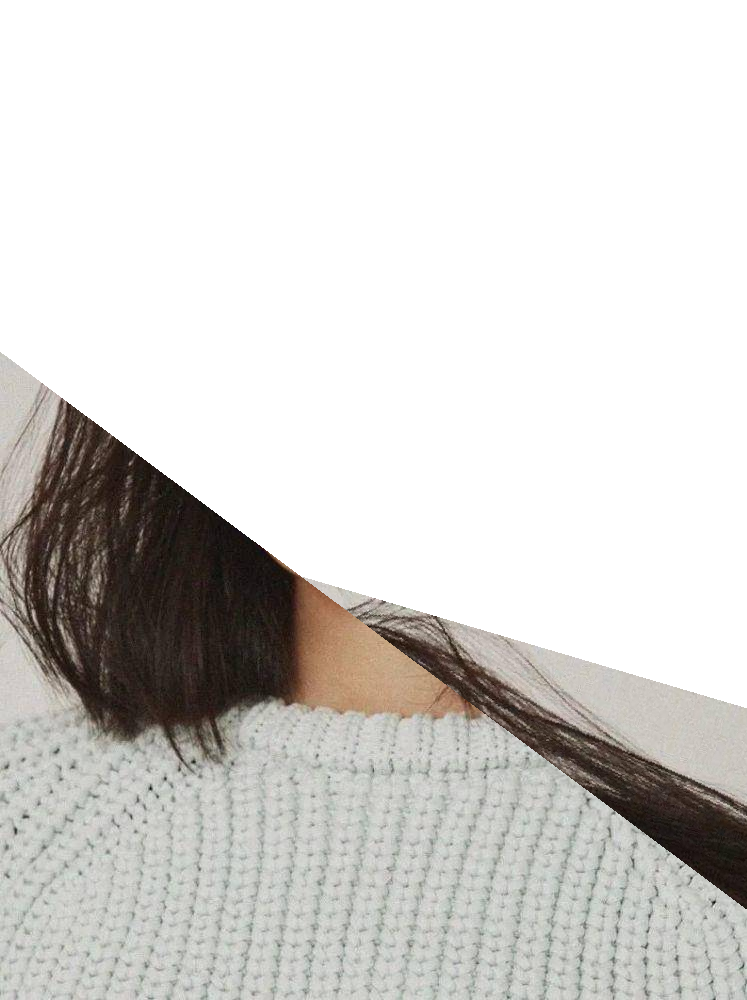

In [151]:
import numpy as np
from PIL import Image
import math
import io
from PIL import Image as PILImage

class PageTurnEffect:
    def __init__(self):
        # 常量定义
        self.PI = 3.14159265359
        self.FOLD_RADIUS = 0.2
        self.OPACITY = 0.5
        self.EPSILON = 1e-5

    def if_less_than(self, val, compare_val):
        return max(np.sign(compare_val - val), 0.0)

    def if_greater_than(self, val, compare_val):
        return max(np.sign(val - compare_val), 0.0)

    def process_image(self, input_image, mouse_pos):
        # 转换输入图像为numpy数组
        img_array = np.array(input_image).astype(np.float32) / 255.0
        height, width = img_array.shape[:2]
        resolution = np.array([width, height])
        aspect_ratio = width / height
        inv_aspect = np.array([1.0 / aspect_ratio, 1.0])
        
        # 创建输出图像数组
        output = img_array.copy()
        
        # 设置折叠位置和方向
        fold_position = np.array(mouse_pos)
        corner_position = np.array([width, 0.0])
        
        # 计算折叠方向和角度
        dir_vector = fold_position - corner_position
        dir_vector = dir_vector / (np.linalg.norm(dir_vector) + self.EPSILON)
        fold_angle = np.arctan2(dir_vector[1], dir_vector[0])

        # 处理每个像素
        for y in range(height):
            for x in range(width):
                uv = np.array([x, y]) / resolution
                uv[0] *= aspect_ratio
                
                normalized_fold_pos = fold_position * np.array([aspect_ratio, 1.0]) / resolution
                
                # 计算卷曲效果
                origin = normalized_fold_pos - dir_vector * (
                    (normalized_fold_pos[0] - aspect_ratio * self.if_greater_than(dir_vector[0], -self.EPSILON)) / 
                    (dir_vector[0] + self.EPSILON)
                )
                
                curl_dist = np.linalg.norm(normalized_fold_pos - origin)
                
                # 计算投影和距离
                proj = np.dot(origin - uv, dir_vector)
                dist = proj - curl_dist
                line_point = uv + dist * dir_vector
                
                # 根据距离应用不同的效果
                if dist > self.FOLD_RADIUS:
                    # 翻转效果
                    relative_pos = np.array([x, y]) - fold_position
                    rotation_matrix = np.array([
                        [np.cos(2 * fold_angle), -np.sin(2 * fold_angle)],
                        [np.sin(2 * fold_angle), np.cos(2 * fold_angle)]
                    ])
                    flipped_pos = fold_position + np.dot(rotation_matrix, relative_pos)
                    flipped_pos = flipped_pos.astype(int)
                    
                    if (0 <= flipped_pos[0] < width and 0 <= flipped_pos[1] < height):
                        output[y, x] = img_array[flipped_pos[1], flipped_pos[0]]
                
                    else:
                        #continue
                        output[y, x] = [0, 0, 0, 0]
                        
                elif dist > self.EPSILON:
                    # 卷曲效果
                    theta = math.asin(min(dist / self.FOLD_RADIUS, 1.0))
                    p1 = line_point - dir_vector * theta * self.FOLD_RADIUS
                    p2 = line_point - dir_vector * (self.PI - theta) * self.FOLD_RADIUS
                    
                    p1_coords = (p1 * inv_aspect * resolution).astype(int)
                    p2_coords = (p2 * inv_aspect * resolution).astype(int)
                    
                    if (0 <= p1_coords[0] < width and 0 <= p1_coords[1] < height and
                        0 <= p2_coords[0] < width and 0 <= p2_coords[1] < height):
                        front_color = img_array[p1_coords[1], p1_coords[0]]
                        back_color = img_array[p2_coords[1], p2_coords[0]]
                        
                        # 光照效果
                        light = ((self.FOLD_RADIUS - dist) / self.FOLD_RADIUS) * 0.3
                        back_color = np.minimum(back_color + light, 1.0)
                        
                        # 混合颜色
                        output[y, x] = np.clip(
                            front_color * (1 - self.OPACITY) + back_color * self.OPACITY, 
                            0, 1
                        )
                    


        return Image.fromarray((output * 255).astype(np.uint8))

class PageTurn:
    def __init__(self, input_image):
        """
        初始化页面翻转效果
        
        Args:
            input_image: PIL.Image 对象
        """
        self.effect = PageTurnEffect()
        self.input_image = input_image
        self.width, self.height = self.input_image.size
    
    @staticmethod
    def ease_in_out_cubic(x):
        """缓动函数，使动画更自然"""
        if x < 0.5:
            return 4 * x * x * x
        else:
            return 1 - pow(-2 * x + 2, 3) / 2

    def calculate_fold_position(self, progress):
        """
        计算指定进度的折叠位置
        
        Args:
            progress (float): 动画进度，范围 0.0 到 1.0
        """
        # 确保进度在有效范围内
        progress = max(0.0, min(1.0, progress))
        
        # 定义折叠路径
        start_pos = np.array([self.width, 0])
        end_pos = np.array([0, self.height])
        
        # 使用缓动函数
        eased_progress = self.ease_in_out_cubic(progress)
        current_pos = start_pos + (end_pos - start_pos) * eased_progress
        
        return current_pos

    def generate_frame(self, progress):
        """
        生成指定进度的翻页效果图片
        
        Args:
            progress (float): 动画进度，范围 0.0 到 1.0
            
        Returns:
            PIL.Image: 处理后的图片
        """
        fold_pos = self.calculate_fold_position(progress)
        return self.effect.process_image(self.input_image, fold_pos)


def main():
    # 使用自定义图片
    input_image = Image.open('input.jpg').convert('RGBA')
    
    page_turn = PageTurn(input_image)
    progress = 0.6  # 设置进度
    result_image = page_turn.generate_frame(progress)
    
    return result_image

# 直接运行代码并返回结果
result = main()
result  # 在Jupyter notebook中显示结果图片

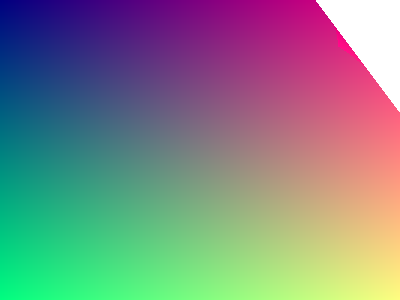

In [176]:
import numpy as np
from PIL import Image
import math
import io
from PIL import Image as PILImage

class PageTurnEffect:
    def __init__(self):
        # 常量定义
        self.PI = 3.14159265359
        self.FOLD_RADIUS = 0.2
        self.OPACITY = 1
        self.EPSILON = 1e-5

    def if_less_than(self, val, compare_val):
        return max(np.sign(compare_val - val), 0.0)

    def if_greater_than(self, val, compare_val):
        return max(np.sign(val - compare_val), 0.0)

    def process_image(self, input_image, mouse_pos):
        # 转换输入图像为numpy数组
        img_array = np.array(input_image).astype(np.float32) / 255.0
        height, width = img_array.shape[:2]
        resolution = np.array([width, height])
        aspect_ratio = width / height
        inv_aspect = np.array([1.0 / aspect_ratio, 1.0])
        
        # 创建输出图像数组
        output = img_array.copy()
        
        # 设置折叠位置和方向
        fold_position = np.array(mouse_pos)
        corner_position = np.array([width, 0.0])
        
        # 计算折叠方向和角度
        dir_vector = fold_position - corner_position
        dir_vector = dir_vector / (np.linalg.norm(dir_vector) + self.EPSILON)
        fold_angle = np.arctan2(dir_vector[1], dir_vector[0])

        # 处理每个像素
        for y in range(height):
            for x in range(width):
                uv = np.array([x, y]) / resolution
                uv[0] *= aspect_ratio
                
                normalized_fold_pos = fold_position * np.array([aspect_ratio, 1.0]) / resolution
                
                # 计算卷曲效果
                origin = normalized_fold_pos - dir_vector * (
                    (normalized_fold_pos[0] - aspect_ratio * self.if_greater_than(dir_vector[0], -self.EPSILON)) / 
                    (dir_vector[0] + self.EPSILON)
                )
                
                curl_dist = np.linalg.norm(normalized_fold_pos - origin)
                
                # 计算投影和距离
                proj = np.dot(origin - uv, dir_vector)
                dist = proj - curl_dist
                line_point = uv + dist * dir_vector
                
                # 根据距离应用不同的效果
                if dist > self.FOLD_RADIUS:
                    output[y, x] = [0, 0, 0, 0]
                        
                elif dist > self.EPSILON:
                    # 卷曲效果
                    theta = math.asin(min(dist / self.FOLD_RADIUS, 1.0))
                    p1 = line_point - dir_vector * theta * self.FOLD_RADIUS
                    p2 = line_point - dir_vector * (self.PI - theta) * self.FOLD_RADIUS
                    
                    p1_coords = (p1 * inv_aspect * resolution).astype(int)
                    p2_coords = (p2 * inv_aspect * resolution).astype(int)
                    
                    if (0 <= p1_coords[0] < width and 0 <= p1_coords[1] < height and
                        0 <= p2_coords[0] < width and 0 <= p2_coords[1] < height):
                        front_color = img_array[p1_coords[1], p1_coords[0]]
                        back_color = img_array[p2_coords[1], p2_coords[0]]
                        
                        # 光照效果
                        light = ((self.FOLD_RADIUS - dist) / self.FOLD_RADIUS) * 0.3
                        back_color = np.minimum(back_color + light, 1.)
                        
                        # 混合颜色
                        output[y, x] = np.clip(
                            front_color * (1 - self.OPACITY) + back_color * self.OPACITY, 
                            0, 1
                        )
                    


        return Image.fromarray((output * 255).astype(np.uint8))

class PageTurn:
    def __init__(self, input_image):
        """
        初始化页面翻转效果
        
        Args:
            input_image: PIL.Image 对象
        """
        self.effect = PageTurnEffect()
        self.input_image = input_image
        self.width, self.height = self.input_image.size
    
    @staticmethod
    def ease_in_out_cubic(x):
        """缓动函数，使动画更自然"""
        if x < 0.5:
            return 4 * x * x * x
        else:
            return 1 - pow(-2 * x + 2, 3) / 2

    def calculate_fold_position(self, progress):
        """
        计算指定进度的折叠位置
        
        Args:
            progress (float): 动画进度，范围 0.0 到 1.0
        """
        # 确保进度在有效范围内
        progress = max(0.0, min(1.0, progress))
        
        # 定义折叠路径
        start_pos = np.array([self.width, 0])
        end_pos = np.array([0, self.height])
        
        # 使用缓动函数
        eased_progress = self.ease_in_out_cubic(progress)
        current_pos = start_pos + (end_pos - start_pos) * eased_progress
        
        return current_pos

    def generate_frame(self, progress):
        """
        生成指定进度的翻页效果图片
        
        Args:
            progress (float): 动画进度，范围 0.0 到 1.0
            
        Returns:
            PIL.Image: 处理后的图片
        """
        fold_pos = self.calculate_fold_position(progress)
        return self.effect.process_image(self.input_image, fold_pos)


def main():
    # 使用自定义图片
    input_image = Image.open('output_sample.png').convert('RGBA')
    
    page_turn = PageTurn(input_image)
    progress = 0.4  # 设置进度
    result_image = page_turn.generate_frame(progress)
    
    return result_image

# 直接运行代码并返回结果
result = main()
result  # 在Jupyter notebook中显示结果图片